### Notebook Structure

This notebook serves as an exploration of the raw traces before any spike sorting.

1. **Example1 (organoid for one experiment time) and Example2 (same key but for the next day experimentation)**
2. **Load data as a SpikeInterface object**
3. **Represent raw traces**
4. **Power spectrum shows an artifact at 5 kHz**
5. **Low-pass filter <4.5kHz removes this artifact**


In [1]:
import os

if os.path.basename(os.getcwd()) == "illustration":
    os.chdir("..")
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [2]:
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.widgets as sw
import matplotlib.pyplot as pl

In [3]:
from workflow.utils.paths import (
    get_ephys_root_data_dir,
    get_raw_root_data_dir,
    get_processed_root_data_dir,
)
from element_interface.utils import dict_to_uuid, find_full_path, find_root_directory

from workflow.pipeline import *

[2024-06-05 01:36:27,282][INFO]: Connecting milagros@db.datajoint.com:3306
[2024-06-05 01:36:28,741][INFO]: Connected milagros@db.datajoint.com:3306


### Example 1 "O09 2023-05-18 12:25-12:30"


Let's take this organoid id and start and end times as an example for this notebook:


In [5]:
session_info = dict(
    organoid_id="O09",
    experiment_start_time="2023-05-18 12:25:00",
    insertion_number=0,
    start_time="2023-05-18 12:25:00",
    end_time="2023-05-18 12:30:00",
    session_type="spike_sorting",
)

This is the corresponding ephys session for this example:


In [6]:
ephys.EphysSession & session_info

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,session_type
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,spike_sorting


In [7]:
channel_ids = ["0", "1", "2", "3", "4"]

With the following lines, the corresponding intan files for the 5 min duration (from 12:25 to 12:29) are listed:


In [8]:
# These are the corresponding intan files for this session.
query = culture.Experiment().proj("drug_name") * ephys.EphysSession & {
    "session_type": "spike_sorting"
}

In [9]:
query & session_info

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,drug_name,session_type
O09,2023-05-18 12:25:00,0,2023-05-18 12:25:00,2023-05-18 12:30:00,4-AP,spike_sorting


In [11]:
key = (query & session_info).fetch1()

In [12]:
title = "_".join(
    [
        key["organoid_id"],
        key["start_time"].strftime("%Y%m%d%H%M"),
        key["end_time"].strftime("%Y%m%d%H%M"),
        key["drug_name"].replace(" ", ""),
    ]
)

spike_sorting_path = get_processed_root_data_dir() / "spike_sorting" / title
spike_sorting_path.mkdir(exist_ok=True, parents=True)

files, file_times = (
    ephys.EphysRawFile
    & f"file_time BETWEEN '{key['start_time']}' AND '{key['end_time']}'"
).fetch("file_path", "file_time", order_by="file_time")

[print(file) for file in files]
print(f"\nNumber of files: {len(files)} ({key['drug_name']})")

O09-12_raw/processed_O9-12_230518_122506.rhd
O09-12_raw/processed_O9-12_230518_122606.rhd
O09-12_raw/processed_O9-12_230518_122706.rhd
O09-12_raw/processed_O9-12_230518_122806.rhd
O09-12_raw/processed_O9-12_230518_122906.rhd

Number of files: 5 (4-AP)


After downloading the RHD files locally, they are loaded and concatenated as a recording object using spikeinterface. This approach ensures that multiple recordings are combined into a single continuous recording:


In [13]:
stream_name = "RHD2000 amplifier channel"

recording = None
t_start = file_times[0]
for file in [find_full_path(get_ephys_root_data_dir(), f) for f in files]:
    print(f"Processing {file}.")
    if not recording:
        recording = si.extractors.read_intan(file, stream_name=stream_name)
    else:
        recording = si.concatenate_recordings(
            [recording, si.extractors.read_intan(file, stream_name=stream_name)]
        )
recording

Processing /Users/milagros/Documents/data/organoids/inbox/O09-12_raw/processed_O9-12_230518_122506.rhd.
Processing /Users/milagros/Documents/data/organoids/inbox/O09-12_raw/processed_O9-12_230518_122606.rhd.
Processing /Users/milagros/Documents/data/organoids/inbox/O09-12_raw/processed_O9-12_230518_122706.rhd.
Processing /Users/milagros/Documents/data/organoids/inbox/O09-12_raw/processed_O9-12_230518_122806.rhd.
Processing /Users/milagros/Documents/data/organoids/inbox/O09-12_raw/processed_O9-12_230518_122906.rhd.


ConcatenateSegmentRecording: 128 channels - 20.0kHz - 1 segments - 6,000,000 samples 
                             300.00s (5.00 minutes) - uint16 dtype - 1.43 GiB

The object is saved locally for more testing purposes:


In [14]:
# recording.save(
#     folder="/Users/milagros/Documents/datajoint-elements/utah_organoids/recording_example"
# )

The recording has scaling (gain_to_uV property), so traces have to be scaled to uV by setting `return_scaled=True` as below:


In [15]:
recording.has_scaled_traces()

True

In [16]:
recording.get_channel_gains()

array([0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195,
       0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195,
       0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195,
       0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195,
       0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195,
       0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195,
       0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195,
       0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195,
       0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195,
       0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195,
       0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195,
       0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195,
       0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195,
       0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.195,
       0.195, 0.195]

In [17]:
traces = recording.get_traces(channel_ids=channel_ids, return_scaled=True)
traces.shape

(6000000, 5)

6,000,000 time samples across 128 channels.


Let's save the raw traces as a numpy object for possible more testing:


In [18]:
# np.save("example_traces.npy", traces)

Let's extract the sample rate and the timestamps from the spikeinterface `recording` object:


In [19]:
sample_rate = recording.sampling_frequency  # Hz
sample_rate

20000.0

In [21]:
timestamp = recording.get_times()  # get timestamps
# np.save("timestamps.npy", timestamp)
timestamp.shape

(6000000,)

In [22]:
recording.get_duration()  # seconds

300.0

Let's represent some of the raw traces:


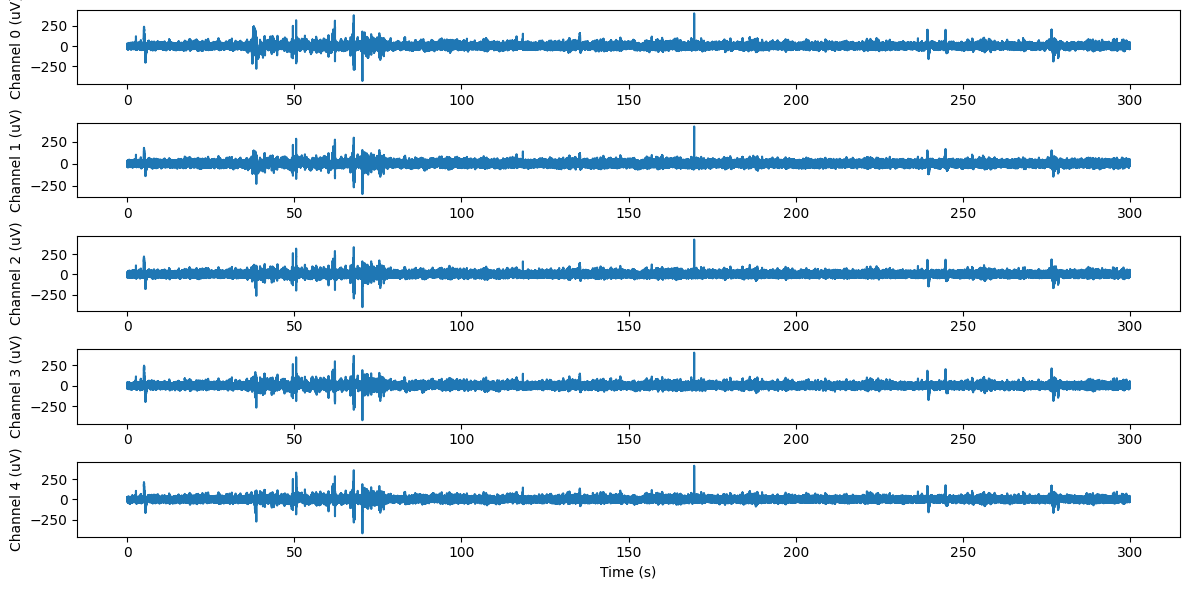

In [23]:
fig, axes = plt.subplots(5, 1, figsize=(12, 6))
axes[0].plot(timestamp, traces[:, 0])
axes[1].plot(timestamp, traces[:, 1])
axes[2].plot(timestamp, traces[:, 2])
axes[3].plot(timestamp, traces[:, 3])
axes[4].plot(timestamp, traces[:, 4])
axes[0].set_ylabel("Channel 0 (uV)")
axes[1].set_ylabel("Channel 1 (uV)")
axes[2].set_ylabel("Channel 2 (uV)")
axes[3].set_ylabel("Channel 3 (uV)")
axes[4].set_ylabel("Channel 4 (uV)")
axes[4].set_xlabel("Time (s)")
# axes[0].set_xlim(35, 45)
# axes[1].set_xlim(35, 45)
# axes[2].set_xlim(35, 45)
# axes[3].set_xlim(35, 45)
# axes[4].set_xlim(35, 45)
plt.tight_layout()
plt.show()

### Example 2 same organoid the day after: "O09 2023-05-19"


In [24]:
(
    ephys.EphysSession
    & "organoid_id='O09'"
    & "session_type='spike_sorting'"
    & "experiment_start_time LIKE '2023-05-19%'"
)

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,session_type
O09,2023-05-19 09:30:00,0,2023-05-19 09:30:00,2023-05-19 09:35:00,spike_sorting
O09,2023-05-19 09:30:00,0,2023-05-19 10:00:00,2023-05-19 10:05:00,spike_sorting
O09,2023-05-19 09:30:00,0,2023-05-19 15:30:00,2023-05-19 15:35:00,spike_sorting
O09,2023-05-19 09:30:00,0,2023-05-19 16:14:00,2023-05-19 16:19:00,spike_sorting
O09,2023-05-19 15:45:00,0,2023-05-19 15:45:00,2023-05-19 15:50:00,spike_sorting
O09,2023-05-19 15:45:00,0,2023-05-19 16:10:00,2023-05-19 16:15:00,spike_sorting
O09,2023-05-19 15:45:00,0,2023-05-19 16:14:00,2023-05-19 16:19:00,spike_sorting


In [25]:
session_info_2 = dict(
    organoid_id="O09",
    experiment_start_time="2023-05-19 09:30:00",
    insertion_number=0,
    start_time="2023-05-19 10:00:00",
    end_time="2023-05-19 10:05:00",
    session_type="spike_sorting",
)

In [26]:
# These are the corresponding intan files for this session.
query = culture.Experiment().proj("drug_name") * ephys.EphysSession & {
    "session_type": "spike_sorting"
}
key = (query & session_info_2).fetch1()

title = "_".join(
    [
        key["organoid_id"],
        key["start_time"].strftime("%Y%m%d%H%M"),
        key["end_time"].strftime("%Y%m%d%H%M"),
        key["drug_name"].replace(" ", ""),
    ]
)

spike_sorting_path = get_processed_root_data_dir() / "spike_sorting" / title
spike_sorting_path.mkdir(exist_ok=True, parents=True)

files, file_times = (
    ephys.EphysRawFile
    & f"file_time BETWEEN '{key['start_time']}' AND '{key['end_time']}'"
).fetch("file_path", "file_time", order_by="file_time")

[print(file) for file in files]
print(f"\nNumber of files: {len(files)} ({key['drug_name']})")

O09-12_raw/processed_O9-12_230519_100006.rhd
O09-12_raw/processed_O9-12_230519_100106.rhd
O09-12_raw/processed_O9-12_230519_100206.rhd
O09-12_raw/processed_O9-12_230519_100306.rhd
O09-12_raw/processed_O9-12_230519_100406.rhd

Number of files: 5 (Bicuculline)


In [27]:
stream_name = "RHD2000 amplifier channel"

recording2 = None
t_start = file_times[0]
for file in [find_full_path(get_ephys_root_data_dir(), f) for f in files]:
    print(f"Processing {file}.")
    if not recording2:
        recording2 = si.extractors.read_intan(file, stream_name=stream_name)
    else:
        recording2 = si.concatenate_recordings(
            [recording2, si.extractors.read_intan(file, stream_name=stream_name)]
        )
recording2

Processing /Users/milagros/Documents/data/organoids/inbox/O09-12_raw/processed_O9-12_230519_100006.rhd.
Processing /Users/milagros/Documents/data/organoids/inbox/O09-12_raw/processed_O9-12_230519_100106.rhd.
Processing /Users/milagros/Documents/data/organoids/inbox/O09-12_raw/processed_O9-12_230519_100206.rhd.
Processing /Users/milagros/Documents/data/organoids/inbox/O09-12_raw/processed_O9-12_230519_100306.rhd.
Processing /Users/milagros/Documents/data/organoids/inbox/O09-12_raw/processed_O9-12_230519_100406.rhd.


ConcatenateSegmentRecording: 128 channels - 20.0kHz - 1 segments - 6,000,000 samples 
                             300.00s (5.00 minutes) - uint16 dtype - 1.43 GiB

In [28]:
traces2 = recording2.get_traces(channel_ids=channel_ids, return_scaled=True)
traces2.shape

(6000000, 5)

In [29]:
sample_rate2 = recording2.sampling_frequency  # Hz
sample_rate2

20000.0

In [30]:
timestamp2 = recording2.get_times()
timestamp2.shape

(6000000,)

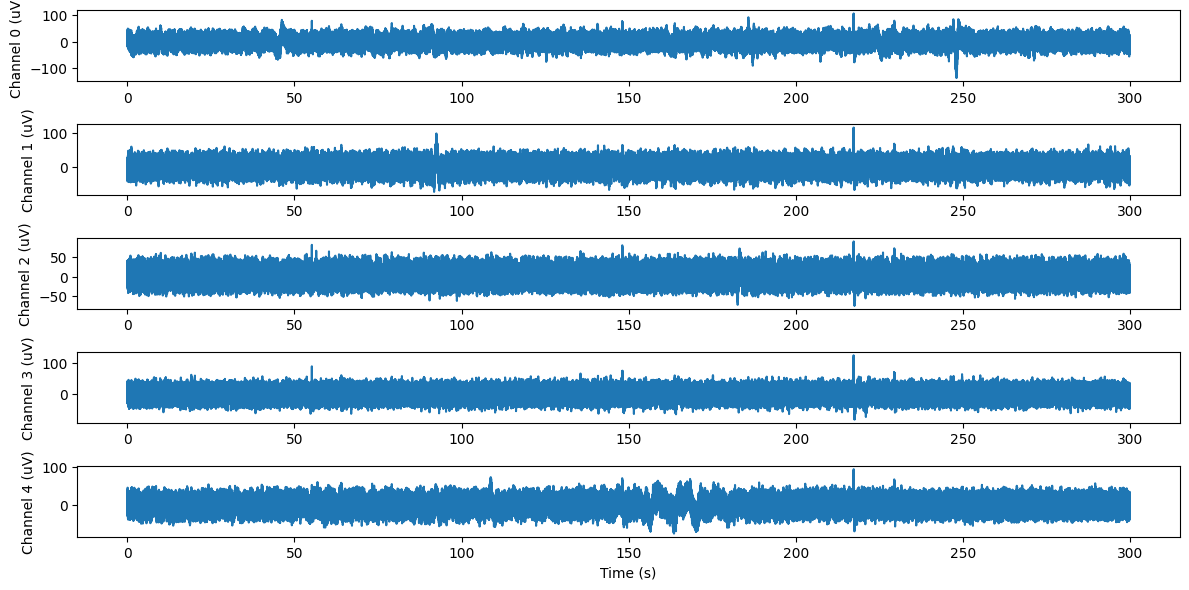

In [31]:
fig, axes = plt.subplots(5, 1, figsize=(12, 6))
axes[0].plot(timestamp2, traces2[:, 0])
axes[1].plot(timestamp2, traces2[:, 1])
axes[2].plot(timestamp2, traces2[:, 2])
axes[3].plot(timestamp2, traces2[:, 3])
axes[4].plot(timestamp2, traces2[:, 4])
axes[0].set_ylabel("Channel 0 (uV)")
axes[1].set_ylabel("Channel 1 (uV)")
axes[2].set_ylabel("Channel 2 (uV)")
axes[3].set_ylabel("Channel 3 (uV)")
axes[4].set_ylabel("Channel 4 (uV)")
axes[4].set_xlabel("Time (s)")
# axes[0].set_xlim(150, 160)
# axes[1].set_xlim(150, 160)
# axes[2].set_xlim(150, 160)
# axes[3].set_xlim(150, 160)
# axes[4].set_xlim(150, 160)
plt.tight_layout()
plt.show()

### Compute and plot the power spectrum before and after low-pass filter


In [32]:
from scipy.signal import find_peaks


def plot_power_spectrum(
    signal, sample_rate, title, height_threshold=0, min_distance_hz=10
):
    fft_result = np.fft.rfft(signal)
    power_spectrum = 20 * np.log10(np.abs(fft_result))
    frequencies = np.fft.rfftfreq(len(signal), 1 / sample_rate)

    frequency_resolution = frequencies[1] - frequencies[0]
    # Convert min_distance_hz to equivalent number of sample steps
    min_distance_steps = int(min_distance_hz / frequency_resolution)

    peaks, properties = find_peaks(
        power_spectrum, height=height_threshold, distance=min_distance_steps
    )
    peak_frequencies = frequencies[peaks]
    peak_powers = power_spectrum[peaks]

    plt.figure(figsize=(10, 6))
    plt.plot(frequencies / 1e3, power_spectrum, label="Power Spectrum")
    plt.plot(peak_frequencies / 1e3, peak_powers, "r*", label="Detected Peaks")
    plt.xlabel("Frequency (kHz)")
    plt.ylabel(
        "Power (dB)"
    )  # Decibels provide a logarithmic scale, which compresses the wide range of power values into a more manageable and interpretable form.
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Print peak frequencies and their power values
    print("Detected peak frequencies (kHz):")
    for freq, power in zip(peak_frequencies, peak_powers):
        print(f"{freq / 1e3:.3f} kHz, Power: {power:.2f} dB")

#### Channel 0


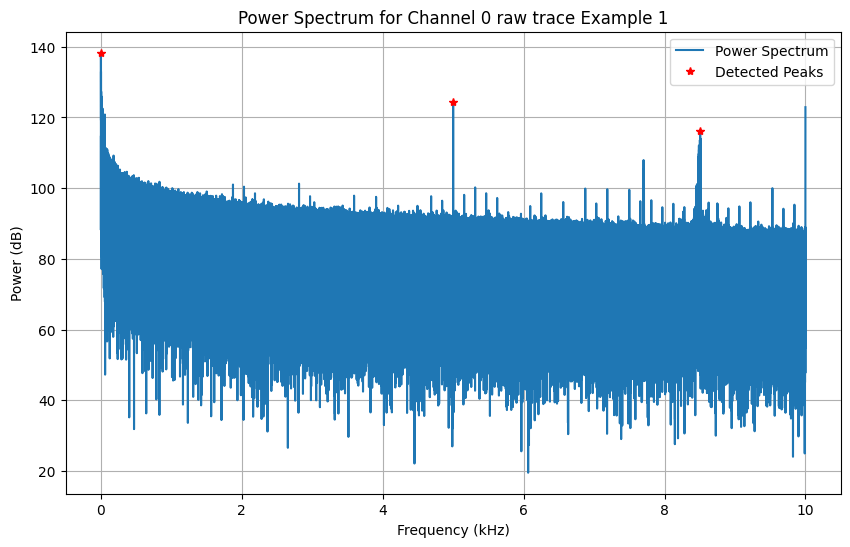

Detected peak frequencies (kHz):
0.001 kHz, Power: 138.29 dB
5.000 kHz, Power: 124.24 dB
8.505 kHz, Power: 116.29 dB


In [33]:
plot_power_spectrum(
    traces[:, 0],
    sample_rate,
    "Power Spectrum for Channel 0 raw trace Example 1",
    height_threshold=110,
    min_distance_hz=250,
)

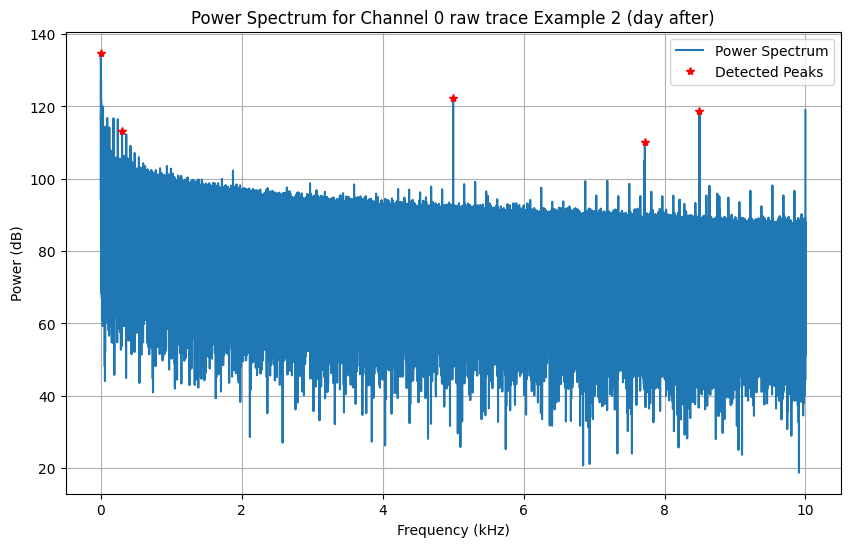

Detected peak frequencies (kHz):
0.000 kHz, Power: 134.87 dB
0.300 kHz, Power: 113.33 dB
5.000 kHz, Power: 122.42 dB
7.721 kHz, Power: 110.06 dB
8.497 kHz, Power: 118.65 dB


In [34]:
plot_power_spectrum(
    traces2[:, 0],
    sample_rate,
    "Power Spectrum for Channel 0 raw trace Example 2 (day after)",
    height_threshold=110,
    min_distance_hz=250,
)

#### Channel 1


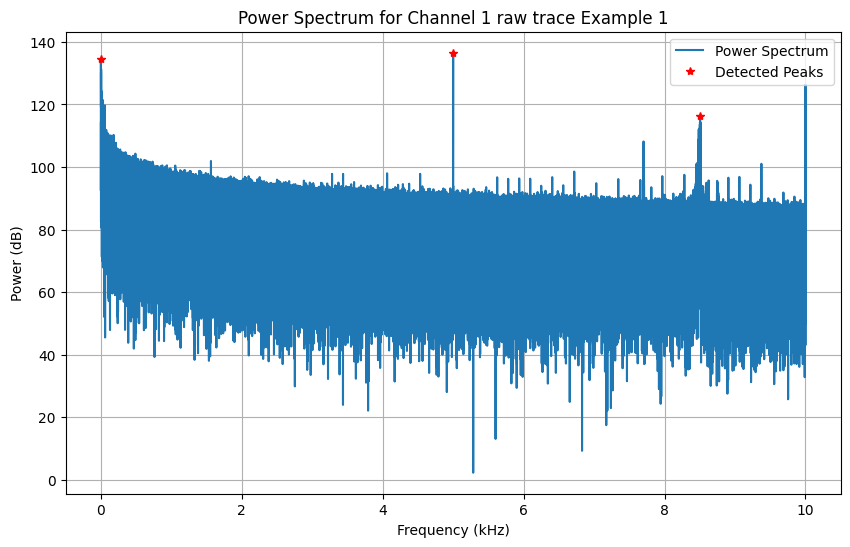

Detected peak frequencies (kHz):
0.000 kHz, Power: 134.47 dB
5.000 kHz, Power: 136.52 dB
8.505 kHz, Power: 116.23 dB


In [35]:
plot_power_spectrum(
    traces[:, 1],
    sample_rate,
    "Power Spectrum for Channel 1 raw trace Example 1",
    height_threshold=110,
    min_distance_hz=250,
)

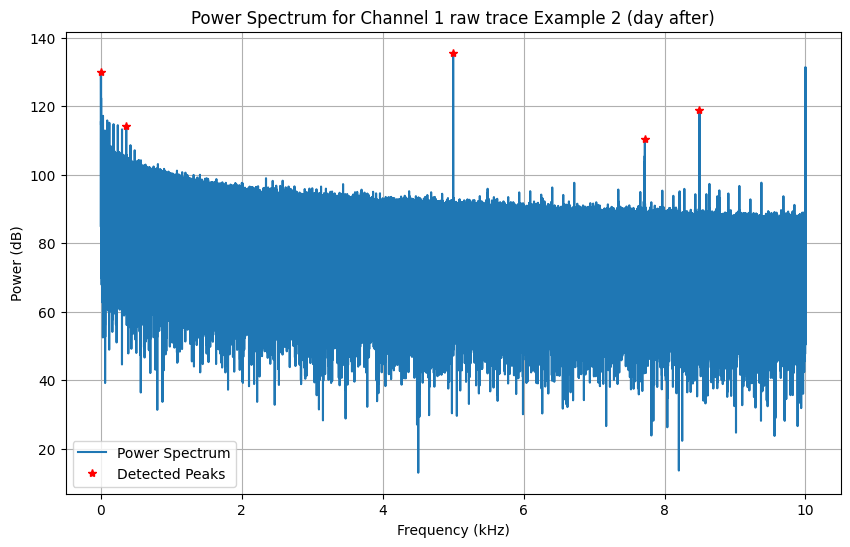

Detected peak frequencies (kHz):
0.000 kHz, Power: 130.04 dB
0.360 kHz, Power: 114.22 dB
5.000 kHz, Power: 135.62 dB
7.721 kHz, Power: 110.50 dB
8.497 kHz, Power: 118.88 dB


In [36]:
plot_power_spectrum(
    traces2[:, 1],
    sample_rate,
    "Power Spectrum for Channel 1 raw trace Example 2 (day after)",
    height_threshold=110,
    min_distance_hz=250,
)

#### Channel 2


/Users/milagros/miniconda/envs/utah_organoids/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


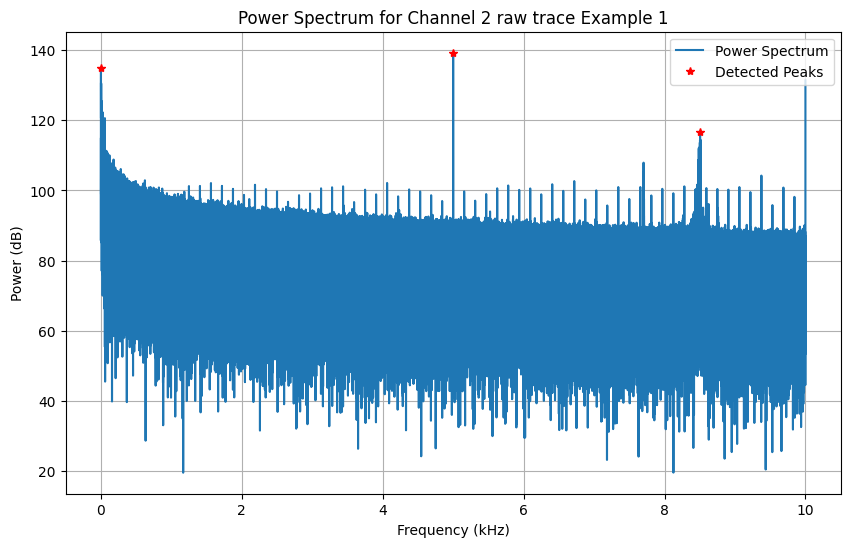

Detected peak frequencies (kHz):
0.001 kHz, Power: 134.89 dB
5.000 kHz, Power: 139.29 dB
8.505 kHz, Power: 116.61 dB


In [37]:
plot_power_spectrum(
    traces[:, 2],
    sample_rate,
    "Power Spectrum for Channel 2 raw trace Example 1",
    height_threshold=110,
    min_distance_hz=250,
)

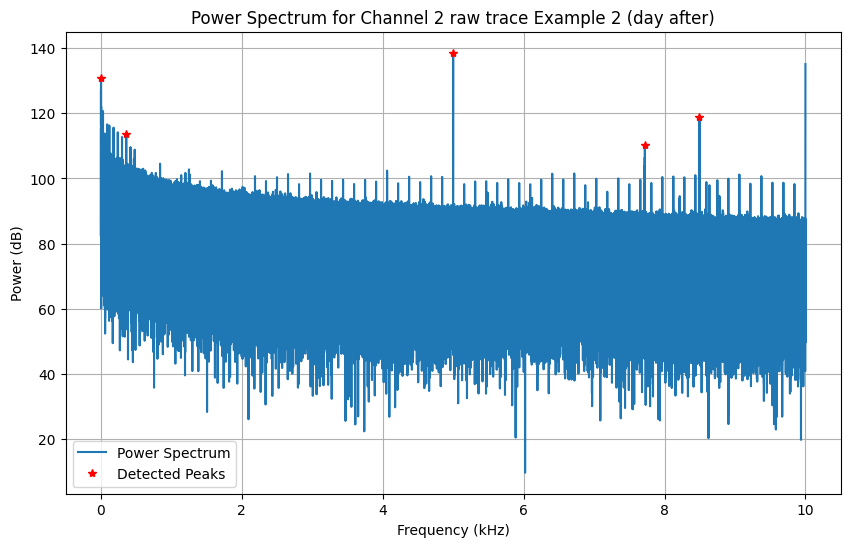

Detected peak frequencies (kHz):
0.002 kHz, Power: 130.82 dB
0.360 kHz, Power: 113.75 dB
5.000 kHz, Power: 138.58 dB
7.721 kHz, Power: 110.25 dB
8.497 kHz, Power: 118.81 dB


In [38]:
plot_power_spectrum(
    traces2[:, 2],
    sample_rate,
    "Power Spectrum for Channel 2 raw trace Example 2 (day after)",
    height_threshold=110,
    min_distance_hz=250,
)

### Apply low-pass filter < 6 kHz -> removes the 7.7 and 8.5 kHz


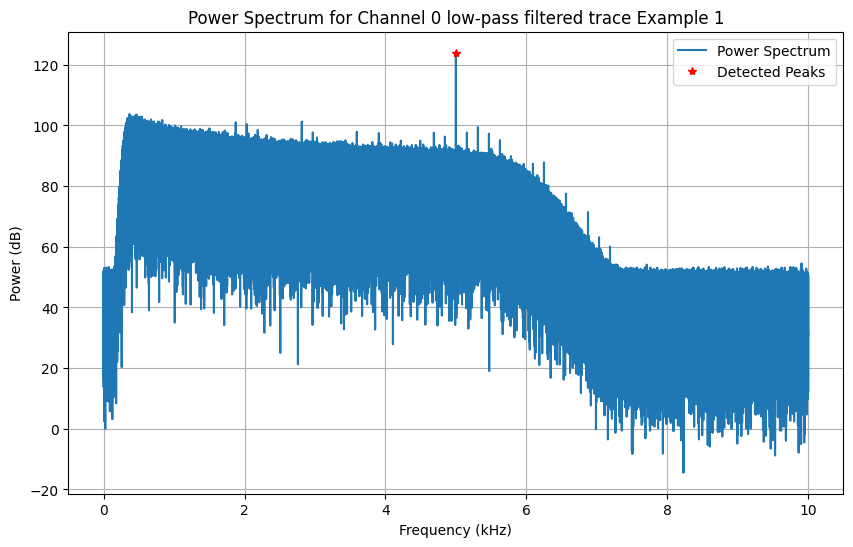

Detected peak frequencies (kHz):
5.000 kHz, Power: 123.99 dB


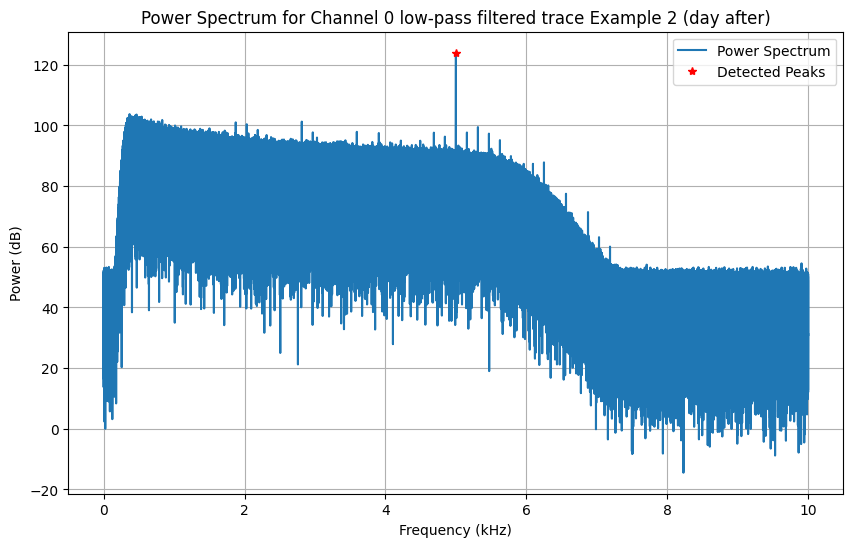

Detected peak frequencies (kHz):
5.000 kHz, Power: 123.99 dB


In [39]:
recording_filtered_example1 = si.preprocessing.bandpass_filter(
    recording=recording, freq_min=300, freq_max=6000
)
traces_filtered_example1 = recording_filtered_example1.get_traces(
    channel_ids=channel_ids, return_scaled=True
)

recording_filtered_example2 = si.preprocessing.bandpass_filter(
    recording=recording2, freq_min=300, freq_max=6000
)
traces_filtered_example2 = recording_filtered_example1.get_traces(
    channel_ids=channel_ids, return_scaled=True
)
sample_rate_filtered = recording_filtered_example1.sampling_frequency
timestamp_filtered = recording_filtered_example1.get_times()

plot_power_spectrum(
    traces_filtered_example1[:, 0],
    sample_rate,
    "Power Spectrum for Channel 0 low-pass filtered trace Example 1",
    height_threshold=110,
    min_distance_hz=250,
)

plot_power_spectrum(
    traces_filtered_example2[:, 0],
    sample_rate,
    "Power Spectrum for Channel 0 low-pass filtered trace Example 2 (day after)",
    height_threshold=110,
    min_distance_hz=250,
)

### Apply low-pass filter < 4.5 kHz -> remove the artifact at 5 kHz


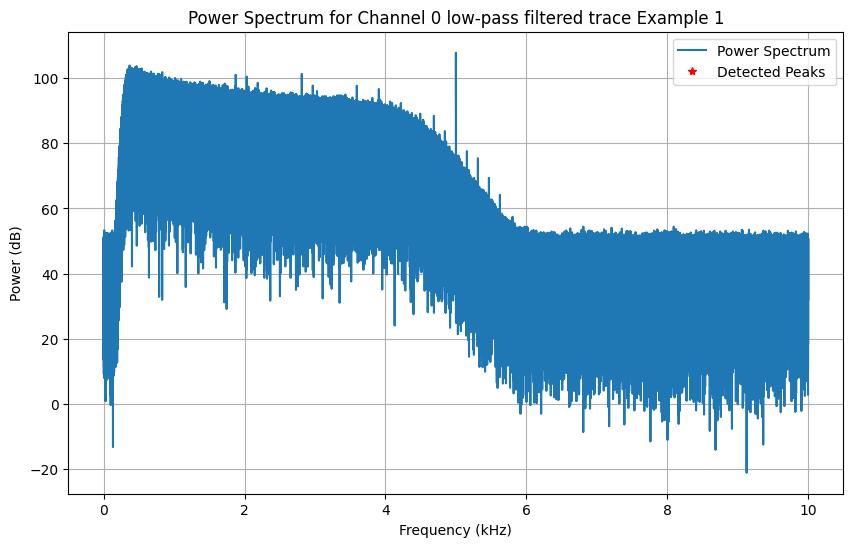

Detected peak frequencies (kHz):


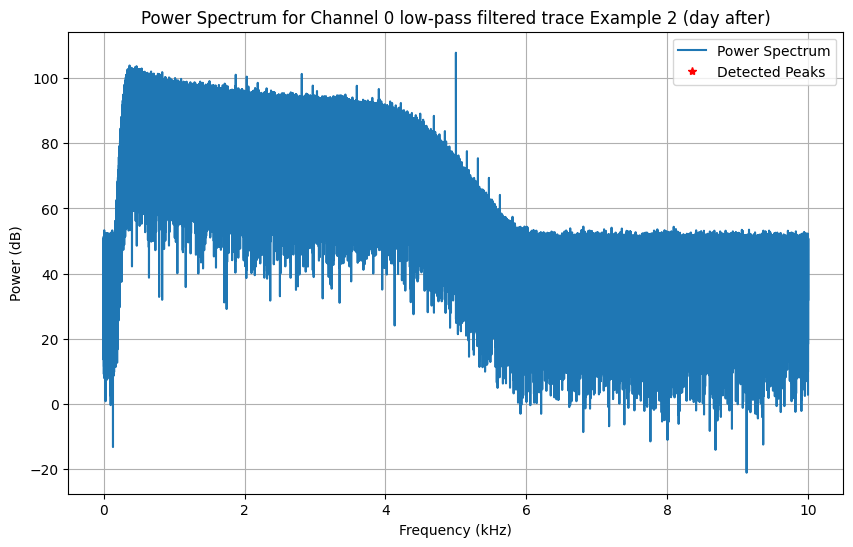

Detected peak frequencies (kHz):


In [40]:
recording_filtered_example1 = si.preprocessing.bandpass_filter(
    recording=recording, freq_min=300, freq_max=4500
)
traces_filtered_example1 = recording_filtered_example1.get_traces(
    channel_ids=channel_ids, return_scaled=True
)

recording_filtered_example2 = si.preprocessing.bandpass_filter(
    recording=recording2, freq_min=300, freq_max=4500
)
traces_filtered_example2 = recording_filtered_example1.get_traces(
    channel_ids=channel_ids, return_scaled=True
)
sample_rate_filtered = recording_filtered_example1.sampling_frequency
timestamp_filtered = recording_filtered_example1.get_times()

plot_power_spectrum(
    traces_filtered_example1[:, 0],
    sample_rate,
    "Power Spectrum for Channel 0 low-pass filtered trace Example 1",
    height_threshold=110,
    min_distance_hz=250,
)

plot_power_spectrum(
    traces_filtered_example2[:, 0],
    sample_rate,
    "Power Spectrum for Channel 0 low-pass filtered trace Example 2 (day after)",
    height_threshold=110,
    min_distance_hz=250,
)